In [1]:
!pip install pandas numpy matplotlib pymc arviz


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
from statsmodels.tsa.stattools import adfuller
from datetime import timedelta
np.random.seed(42)

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


In [6]:
path = "../data/BrentOilPrices.csv"
try:
    data = pd.read_csv(path)
    data['Date'] = pd.to_datetime(data['Date'], format='mixed', dayfirst=False)
    data = data.sort_values(by='Date').set_index('Date')
    data['Price'] = data['Price'].interpolate(method='time')
    data = data.dropna(subset=['Price'])
    data = data.resample('W').mean().interpolate(method='time')
    data['Log_Return'] = np.log(data['Price']).diff().dropna()
    time_series_price = data['Price']
    time_series_log_return = data['Log_Return'].dropna()
    print("Brent Oil Prices Head:\n", time_series_price.head())
    print("\nBrent Oil Prices Tail:\n", time_series_price.tail())
    print("\nLog Returns Head:\n", time_series_log_return.head())
    print("\nLog Returns Tail:\n", time_series_log_return.tail())
except FileNotFoundError:
    print(f"Error: File '{path}' not found.")
except Exception as e:
    print(f"Error during data loading: {e}")
events = pd.read_csv('../data/events.csv')
events['Date'] = pd.to_datetime(events['Date'], format='%d-%m-%Y')
print("\nEvents:\n", events)

Brent Oil Prices Head:
 Date
1987-05-24    18.543333
1987-05-31    18.602000
1987-06-07    18.702000
1987-06-14    18.754000
1987-06-21    19.007500
Freq: W-SUN, Name: Price, dtype: float64

Brent Oil Prices Tail:
 Date
2022-10-23    91.036
2022-10-30    93.014
2022-11-06    95.862
2022-11-13    96.078
2022-11-20    93.590
Freq: W-SUN, Name: Price, dtype: float64

Log Returns Head:
 Date
1987-05-31    0.003159
1987-06-07    0.005361
1987-06-14    0.002777
1987-06-21    0.013427
1987-06-28   -0.005354
Freq: W-SUN, Name: Log_Return, dtype: float64

Log Returns Tail:
 Date
2022-10-23   -0.038656
2022-10-30    0.021495
2022-11-06    0.030160
2022-11-13    0.002251
2022-11-20   -0.026237
Freq: W-SUN, Name: Log_Return, dtype: float64

Events:
          Date                            Event Description        Category  \
0  1990-08-01                              Gulf War begins        Conflict   
1  1991-01-01  Gulf War escalates (Operation Desert Storm)        Conflict   
2  2001-09-11     

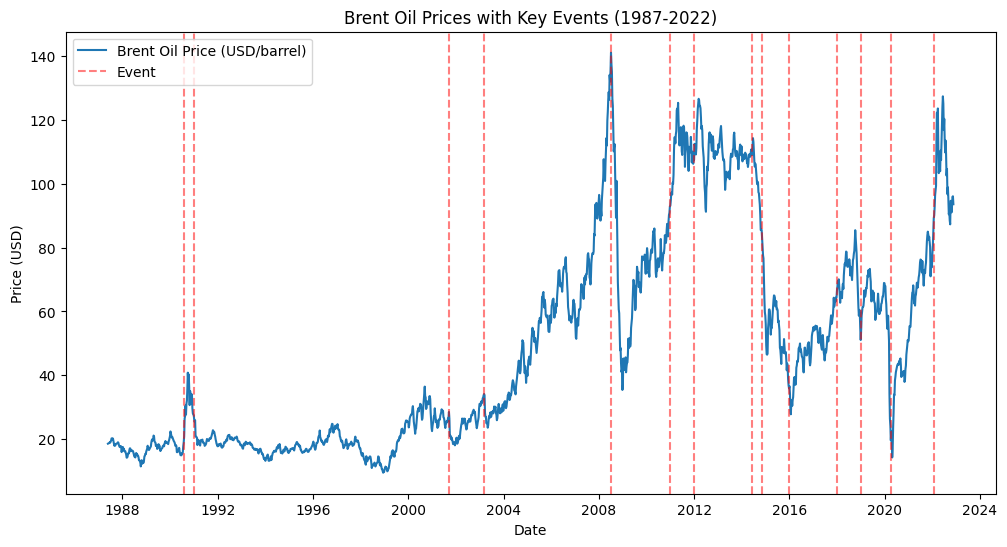

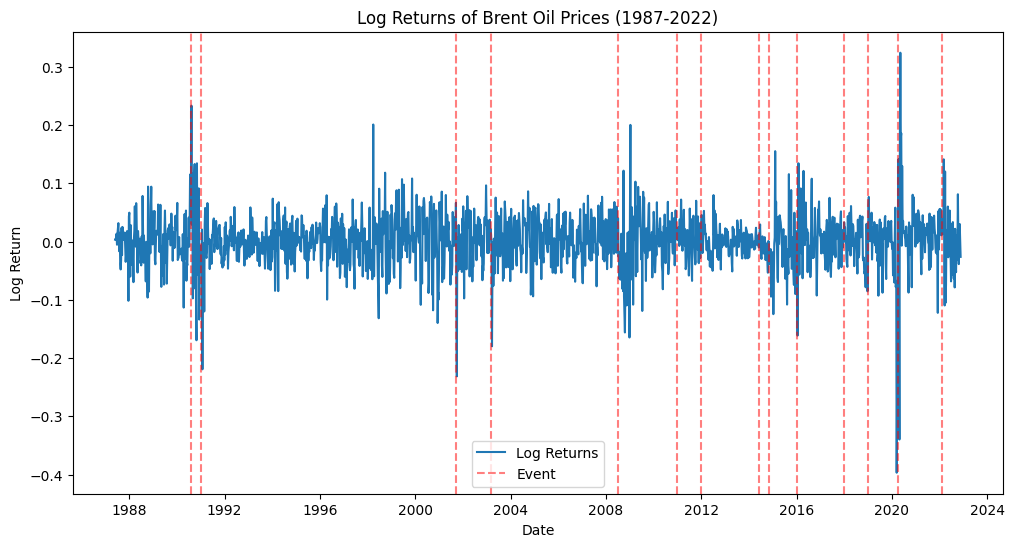

ADF Test for Prices: -1.7560502551650536 p-value: 0.4024893122646962
ADF Test for Log Returns: -16.91940358511483 p-value: 9.966676284584474e-30


In [7]:
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Price'], label='Brent Oil Price (USD/barrel)')
for event_date in events['Date']:
    plt.axvline(event_date, color='red', linestyle='--', alpha=0.5, label='Event' if event_date == events['Date'].iloc[0] else '')
plt.title('Brent Oil Prices with Key Events (1987-2022)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.savefig('../figures/price_series_with_events.png')
plt.show()
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Log_Return'], label='Log Returns')
for event_date in events['Date']:
    plt.axvline(event_date, color='red', linestyle='--', alpha=0.5, label='Event' if event_date == events['Date'].iloc[0] else '')
plt.title('Log Returns of Brent Oil Prices (1987-2022)')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.savefig('../figures/log_returns_with_events.png')
plt.show()
result = adfuller(data['Price'].dropna())
print('ADF Test for Prices:', result[0], 'p-value:', result[1])
result = adfuller(data['Log_Return'].dropna())
print('ADF Test for Log Returns:', result[0], 'p-value:', result[1])

In [8]:
prices = data['Price'].values
time_index = np.arange(len(prices))
with pm.Model() as model:
    tau = pm.DiscreteUniform('tau', lower=0, upper=len(prices)-1)
    mu_1 = pm.Normal('mu_1', mu=np.mean(prices), sigma=10)
    mu_2 = pm.Normal('mu_2', mu=np.mean(prices), sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=10)
    mu = pm.math.switch(time_index < tau, mu_1, mu_2)
    likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=prices)
    trace = pm.sample(500, tune=500, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu_1, mu_2, sigma]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 2097 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
tau    927.824  2.289  922.000  931.000      0.175    0.181     213.0   
mu_1    21.500  0.609   20.385   22.615      0.012    0.012    2652.0   
mu_2    75.667  0.612   74.489   76.816      0.013    0.013    2397.0   
sigma   18.638  0.312   18.065   19.224      0.006    0.007    2630.0   

       ess_tail  r_hat  
tau       162.0   1.02  
mu_1     1666.0   1.00  
mu_2     1572.0   1.00  
sigma    1427.0   1.00  


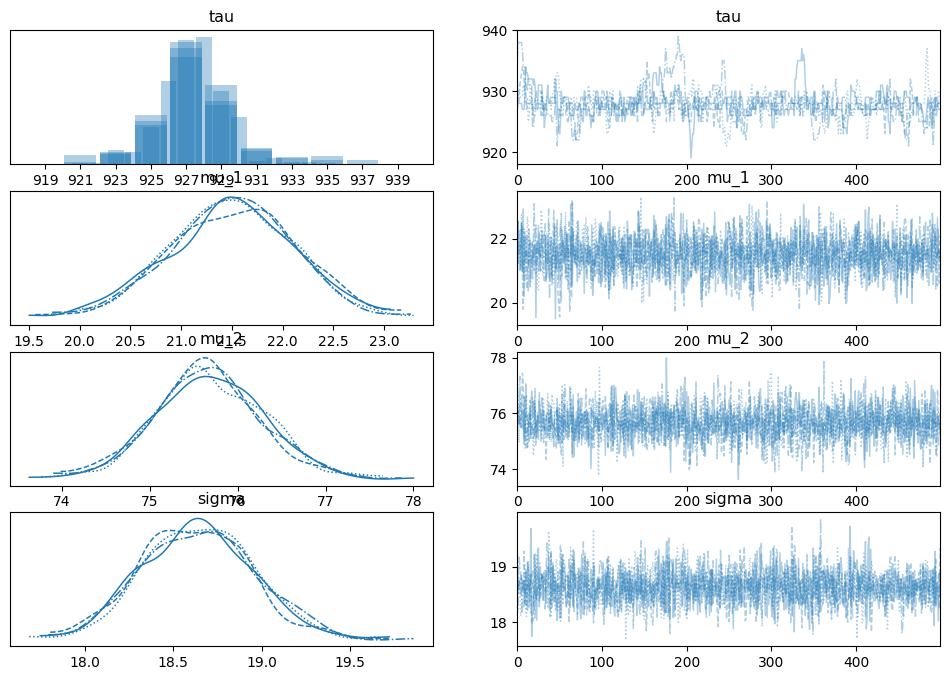

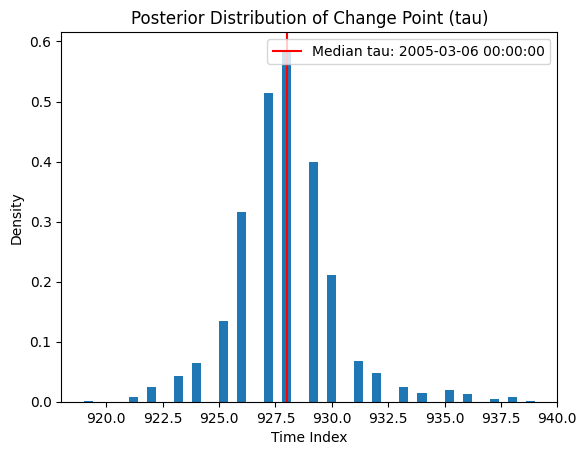

Most likely change point: 2005-03-06 00:00:00


In [9]:
print(az.summary(trace))
az.plot_trace(trace)
plt.savefig('../figures/trace_plot.png')
plt.show()
tau_posterior = trace.posterior['tau'].values.flatten()
tau_date = data.index[np.median(tau_posterior).astype(int)]
plt.hist(tau_posterior, bins=50, density=True)
plt.axvline(np.median(tau_posterior), color='red', label=f'Median tau: {tau_date}')
plt.title('Posterior Distribution of Change Point (tau)')
plt.xlabel('Time Index')
plt.ylabel('Density')
plt.legend()
plt.savefig('../figures/tau_posterior.png')
plt.show()
print(f'Most likely change point: {tau_date}')

In [10]:
window = timedelta(days=30)
relevant_events = events[(events['Date'] >= tau_date - window) & (events['Date'] <= tau_date + window)]
print('Relevant Events:', relevant_events)
mu_1_mean = trace.posterior['mu_1'].mean().values
mu_2_mean = trace.posterior['mu_2'].mean().values
price_change_pct = ((mu_2_mean - mu_1_mean) / mu_1_mean * 100)
print(f'Mean price before: ${mu_1_mean:.2f}, after: ${mu_2_mean:.2f}')
print(f'Price change: {price_change_pct:.2f}%')
change_points = pd.DataFrame({
    'tau_date': [tau_date],
    'mu_1': [mu_1_mean],
    'mu_2': [mu_2_mean],
    'price_change_pct': [price_change_pct],
    'event': [relevant_events['Event Description'].iloc[0] if not relevant_events.empty else 'None'],
    'category': [relevant_events['Category'].iloc[0] if not relevant_events.empty else 'None']
})
change_points.to_csv('../data/change_points.csv', index=False)
print(change_points)

Relevant Events: Empty DataFrame
Columns: [Date, Event Description, Category, Source]
Index: []
Mean price before: $21.50, after: $75.67
Price change: 251.94%
    tau_date                mu_1              mu_2  price_change_pct event  \
0 2005-03-06  21.500235558329972  75.6672428083701        251.936808  None   

  category  
0     None  


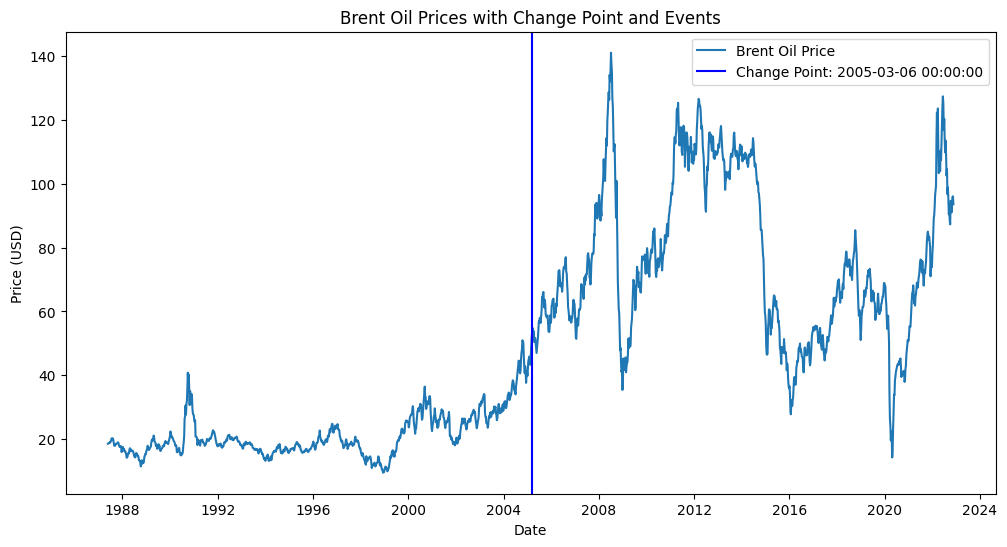

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Price'], label='Brent Oil Price')
plt.axvline(tau_date, color='blue', linestyle='-', label=f'Change Point: {tau_date}')
if not relevant_events.empty:
    for event_date in relevant_events['Date']:
        plt.axvline(event_date, color='red', linestyle='--', alpha=0.5, 
                    label=f'Event: {relevant_events["Event Description"].iloc[0]}')
plt.title('Brent Oil Prices with Change Point and Events')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.savefig('../figures/change_point_plot.png')
plt.show()

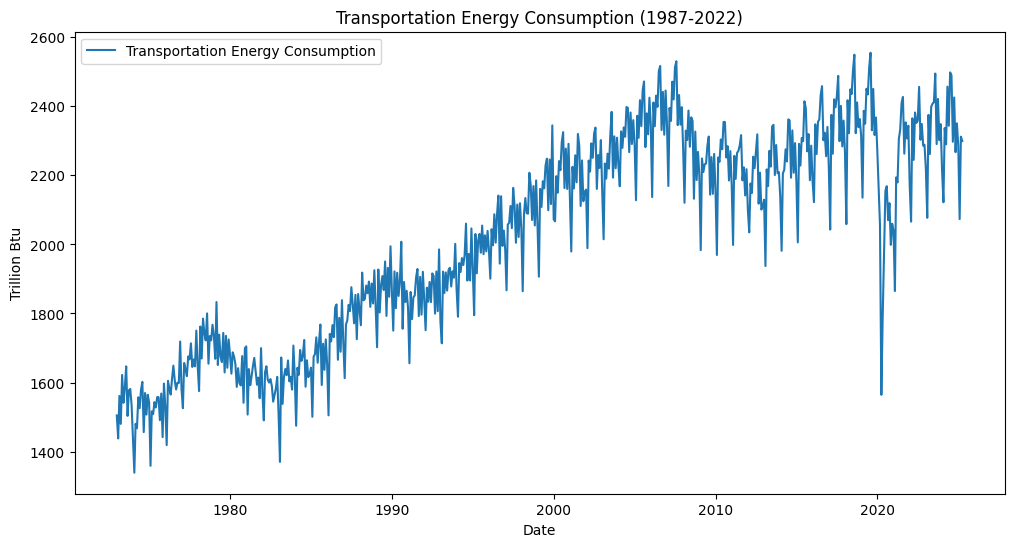

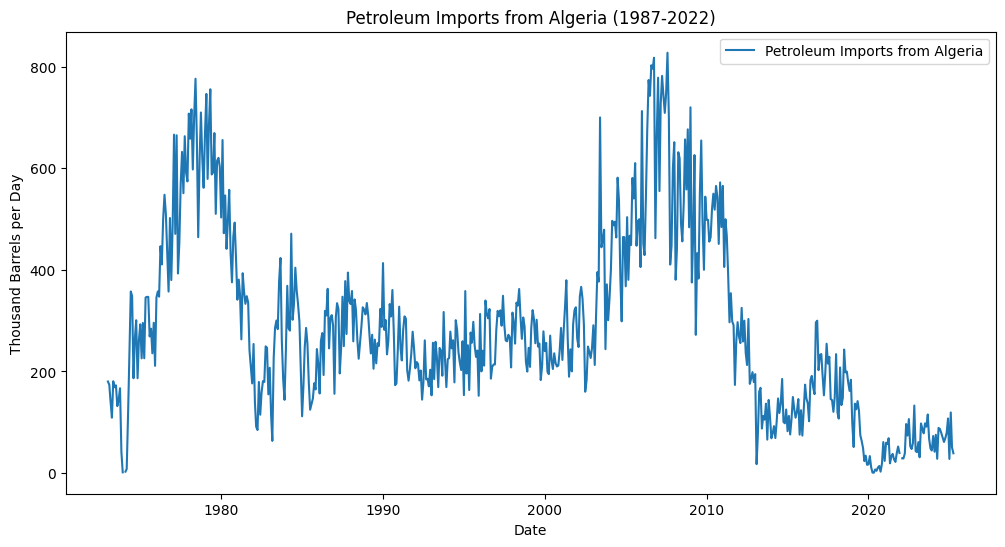

In [14]:
# Load and plot energy consumption
try:
    energy = pd.read_csv('../data/energy_consumption.csv')
    # Clean YYYYMM: Ensure 6-digit format, drop invalid entries
    energy['YYYYMM'] = energy['YYYYMM'].astype(str).str.strip()
    energy = energy[energy['YYYYMM'].str.match(r'^\d{6}$')]  # Keep only 6-digit YYYYMM
    energy['Date'] = pd.to_datetime(energy['YYYYMM'], format='%Y%m', errors='coerce')
    energy = energy.dropna(subset=['Date'])  # Drop rows with invalid dates
    energy = energy[energy['MSN'] == 'TXACBUS'].set_index('Date')
    plt.figure(figsize=(12, 6))
    plt.plot(energy.index, energy['Value'], label='Transportation Energy Consumption')
    plt.title('Transportation Energy Consumption (1987-2022)')
    plt.xlabel('Date')
    plt.ylabel('Trillion Btu')
    plt.legend()
    plt.savefig('../figures/energy_consumption.png')
    plt.show()
except Exception as e:
    print(f"Error processing energy_consumption.csv: {e}")

# Load and plot petroleum trade
try:
    trade = pd.read_csv('../data/petroleum_trade.csv')
    # Clean YYYYMM: Ensure 6-digit format, drop invalid entries
    trade['YYYYMM'] = trade['YYYYMM'].astype(str).str.strip()
    trade = trade[trade['YYYYMM'].str.match(r'^\d{6}$')]  # Keep only 6-digit YYYYMM
    trade['Date'] = pd.to_datetime(trade['YYYYMM'], format='%Y%m', errors='coerce')
    trade = trade.dropna(subset=['Date'])  # Drop rows with invalid dates
    trade = trade[trade['MSN'] == 'PAIMPAG'].set_index('Date')
    trade['Value'] = pd.to_numeric(trade['Value'], errors='coerce')
    plt.figure(figsize=(12, 6))
    plt.plot(trade.index, trade['Value'], label='Petroleum Imports from Algeria')
    plt.title('Petroleum Imports from Algeria (1987-2022)')
    plt.xlabel('Date')
    plt.ylabel('Thousand Barrels per Day')
    plt.legend()
    plt.savefig('../figures/petroleum_trade.png')
    plt.show()
except Exception as e:
    print(f"Error processing petroleum_trade.csv: {e}")